In [ ]:
!pip install matplotlib
!pip install numpy
!pip install opencv-python
!pip install os
!pip install tensorflow
!pip install tqdm

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tqdm import tqdm

In [ ]:
!pip install google.colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
base_path = "/content/drive/MyDrive/deepdata"

Mounted at /content/drive


In [ ]:
categories = ["Real", "Fake"]          # folders


# Video & image settings
num_frames = 10
height, width, channels = 224, 224, 3


# Containers
X = []
y = []



def extract_frames(video_path, num_frames, target_size) :
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_idxs = np.linspace(0, total_frames - 1, num_frames).astype(int)
    frames = []

    for i in range(total_frames) :
        ret, frame = cap.read()
        if not ret :
            break
        if i in frame_idxs :
            frame = cv2.resize(frame, target_size)
            frame = frame.astype("float32") / 255.0
            frames.append(frame)

    cap.release()

    if len(frames) == num_frames :
        return np.array(frames)
    else:
        return None

In [ ]:
for label, category in enumerate(categories) :  # Real = 0, Fake = 1
    folder_path = os.path.join(base_path, category)
    video_files = os.listdir(folder_path)

    for video_name in tqdm(video_files, desc=f"Processing {category}") :
        video_path = os.path.join(folder_path, video_name)
        frames = extract_frames(video_path, num_frames, (height, width))
        if frames is not None :
            X.append(frames)
            y.append(label)

Processing Fake: 100%|██████████| 397/397 [01:09<00:00,  5.68it/s]


In [ ]:
X = np.array(X)
y = np.array(y)
print(X)
print(y)

[[[[[0.5803922  0.36078432 0.21568628]
    [0.58431375 0.36862746 0.21568628]
    [0.58431375 0.36862746 0.21568628]
    ...
    [0.16862746 0.22352941 0.15294118]
    [0.17254902 0.21568628 0.14509805]
    [0.25490198 0.2784314  0.20784314]]

   [[0.58431375 0.35686275 0.20784314]
    [0.5882353  0.36078432 0.21176471]
    [0.5882353  0.36078432 0.21176471]
    ...
    [0.16862746 0.22745098 0.14901961]
    [0.17254902 0.21960784 0.14117648]
    [0.25490198 0.2784314  0.20392157]]

   [[0.5686275  0.36078432 0.21568628]
    [0.5686275  0.36078432 0.21568628]
    [0.5686275  0.36078432 0.21176471]
    ...
    [0.16862746 0.22745098 0.14901961]
    [0.17254902 0.21960784 0.14117648]
    [0.25882354 0.2784314  0.20392157]]

   ...

   [[0.29411766 0.30980393 0.30980393]
    [0.29411766 0.30980393 0.30980393]
    [0.29411766 0.30980393 0.30980393]
    ...
    [0.20392157 0.2        0.23137255]
    [0.2        0.2        0.22352941]
    [0.23529412 0.23137255 0.2509804 ]]

   [[0.2627451  

In [ ]:
# Preprocess the data
X = preprocess_input(X)

In [ ]:
# Build the model
input_layer = Input(shape = (num_frames, height, width, channels))

In [ ]:
# Base CNN model (MobileNetV2)
base_input = Input(shape = (height, width, channels))
base_output = MobileNetV2(weights = "imagenet", include_top = False)(base_input)
base_model = Model(inputs = base_input, outputs = base_output)
base_model.trainable = False

<ipython-input-20-ea44f823bce8>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_output = MobileNetV2(weights = "imagenet", include_top = False)(base_input)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

cnn = TimeDistributed(base_model)(input_layer)
cnn = TimeDistributed(MaxPooling2D(pool_size = (2, 2)))(cnn)
cnn = TimeDistributed(Flatten())(cnn)

In [ ]:
# Add LSTM layer
x = LSTM(64, implementation=1, unroll=True)(cnn)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
out = Dense(1, activation="sigmoid")(x)

model = Model(inputs=input_layer, outputs=out)

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 7, 7, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 3, 3, 1280) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 11520)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     2,965,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,227,969 (19.94 MB)

 Trainable params: 2,969,985 (11.33 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Training
model.fit(X, y, epochs = 5, batch_size = 4, validation_split = 0.2)

Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.9152 - loss: 0.2556 - val_accuracy: 1.0000 - val_loss: 0.0545
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.9446 - loss: 0.2278 - val_accuracy: 1.0000 - val_loss: 0.0494
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9555 - loss: 0.1919 - val_accuracy: 1.0000 - val_loss: 0.0708
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9647 - loss: 0.1603 - val_accuracy: 1.0000 - val_loss: 0.0737
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9385 - loss: 0.2457 - val_accuracy: 1.0000 - val_loss: 0.0613


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = model.predict(X)
y_pred = (y_pred_probs > 0.5).astype(int)

14/14 ━━━━━━━━━━━━━━━━━━━━ 216s 14s/step


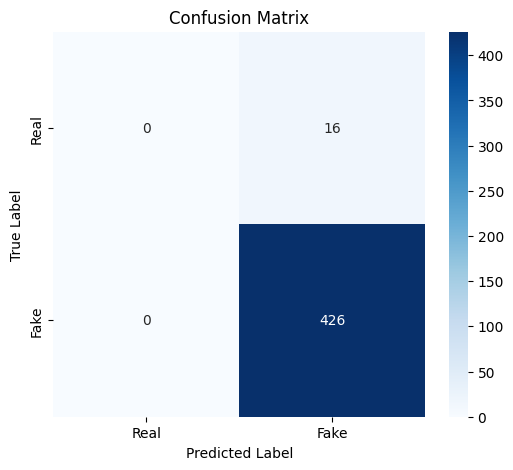

Model Performance Metrics:
Accuracy : 0.9638
Precision: 0.9638
Recall   : 1.0000
F1 Score : 0.9816

Classification Report:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00        16
        Fake       0.96      1.00      0.98       426

    accuracy                           0.96       442
   macro avg       0.48      0.50      0.49       442
weighted avg       0.93      0.96      0.95       442



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


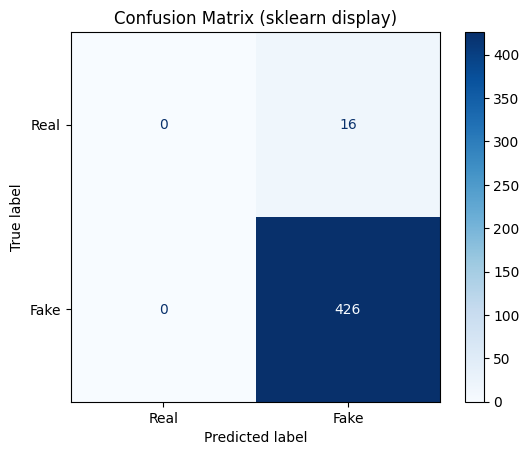

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the confusion matrix
cm = confusion_matrix(y, y_pred)
labels = ["Real", "Fake"]

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Display
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print("Model Performance Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=labels))

# Optional: Use ConfusionMatrixDisplay for a scikit-learn style plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (sklearn display)")
plt.show()
